In [148]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset,DataLoader

import numpy as np
import matplotlib.pyplot as plt

import lightning as L


# Physics Informed Neural Networks (PINNS)

Equation de diffusion de la chaleur $$\dfrac{\partial u}{\partial t} -c^2 \dfrac{\partial^2 u}{\partial^2 x} = 0$$


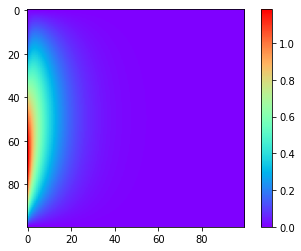

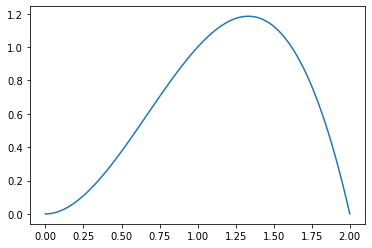

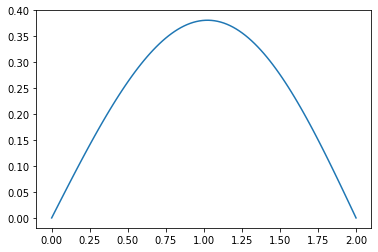

In [149]:
# PDE configurations
alpha = 2
n = 100

U = np.zeros([n,n])
t = np.linspace(0,1,n)
x = np.linspace(0,2,n)
X,T = np.meshgrid(t,x)

for i in range(1,1000):
  C = -32/(i**3*np.pi**3)*(2*(-1)**i+1)
  for j in range(n):
    U[j,...] = U[j,...] + C*np.sin(i*np.pi*x[j]/2)*np.exp(-i**2*np.pi**2*t)

plt.imshow(U, cmap='rainbow')
plt.colorbar()
plt.show()
plt.plot(x,U[:,0])
plt.show()
plt.plot(x,U[:,10])
plt.show()

## Definition du domain

In [150]:
class DatasetTest(Dataset):
    def __init__(self,
                 num_test_x =  120,
                 num_test_t =  120,#60,
                 bounds = [0,2,0,1] # x min, x max, t min, t max
                ):
        self.num_test_x = num_test_x
        self.num_test_t = num_test_t
        self.bounds = bounds

        self.L = self.bounds[1] - self.bounds[0]
        self.T = self.bounds[3] - self.bounds[2]

    def __len__(self):
        return self.num_test_x * self.num_test_t

    def __getitem__(self, idx):
        ix = idx // self.num_test_t
        it = idx  % self.num_test_t

        x = ix * self.L/(self.num_test_x-1) + self.bounds[0]
        t = it * self.T/(self.num_test_t-1) + self.bounds[2]

        u = 0
        for n in range(1,1000):
            C = -32/(n**3*np.pi**3)*(2*(-1)**n+1)            
            #u = u + C*np.sin(n*np.pi*x/2)*np.exp(-(n*np.pi)**2*t)
            u = u + C*np.sin(n*np.pi*x/self.L)*np.exp(-alpha*(n*np.pi/self.L)**2*t)

        return torch.Tensor([x,t]),torch.Tensor([u])

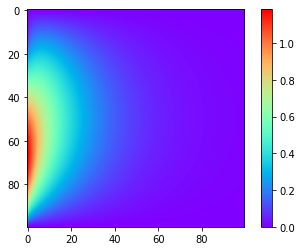

In [151]:
m = n#//2
test = DatasetTest(n,m)
test_loader = DataLoader(test,shuffle=False, batch_size=len(test))
x,y = next(iter(test_loader))
plt.imshow(y.reshape((n,m)),cmap='rainbow')#,vmin=0,vmax = 1.2)
plt.colorbar()
plt.show()
#print(x)


In [152]:
#np.max(np.abs(U-y.reshape((100,100)).numpy()))

In [153]:
class DatasetCollocation(Dataset):
    def __init__(self,
                 nbCollocation =  1500,
                 bounds = [0,2,0,1] # x min, x max, t min, t max
                ):
        self.nbCollocation = nbCollocation
        self.bounds = bounds
        
        # Points intérieurs
        self.p_collocation = torch.rand(nbCollocation,2)
        self.p_collocation[:,0] = self.p_collocation[:,0]*(bounds[1]-bounds[0])+bounds[0]
        self.p_collocation[:,1] = self.p_collocation[:,1]*(bounds[3]-bounds[2])+bounds[2]

    def __len__(self):
        return self.nbCollocation

    def __getitem__(self, idx):
        return self.p_collocation[idx], {'type':1, 'val':torch.Tensor([0])} # 1 pour intérieur, 0 valeur du residu
        

In [154]:
class DatasetTrainIC(Dataset):
    def __init__(self,
                 nbBounds =  500,
                 bounds = [0,2,0,1] # x min, x max, t min, t max
                ):
        self.nbBounds = nbBounds
        self.bounds = bounds

        # points sur les conditions initiales
        # condition initiale
        x = torch.rand(nbBounds)*(bounds[1]-bounds[0])+bounds[0]        
        self.p_bounds = torch.stack((x,torch.zeros(nbBounds)),1) 
        self.u = self.p_bounds[:,0]**2 * (2-self.p_bounds[:,0])
        

    def __len__(self):
        return self.nbBounds

    def __getitem__(self, idx):                    
        return self.p_bounds[idx], {'type':0, 'val':self.u[None,idx]}  # 0 pour bordure

In [155]:
train_loader = DataLoader(DatasetTrainIC(),shuffle=True, batch_size=len(train))
X,info= next(iter(train_loader))

In [158]:
class DatasetTrainBounds(Dataset):
    def __init__(self,
                 nbBounds =  500,
                 bounds = [0,2,0,1] # x min, x max, t min, t max
                ):
        self.nbBounds = nbBounds
        self.bounds = bounds
        
        # points sur les conditions initiales
        # condition aux bords
        t = torch.rand(self.nbBounds//2)*(bounds[3]-bounds[2])+bounds[2]   
        self.p_bounds1 = torch.stack(
            (
                bounds[0]*torch.ones(self.nbBounds//2),
                t
            ),1
        )
        t = torch.rand(self.nbBounds//2+self.nbBounds%2)*(bounds[3]-bounds[2])+bounds[2] 
        self.p_bounds2 = torch.stack(
            (
                bounds[1]*torch.ones(self.nbBounds//2+self.nbBounds%2),
                t
            ),1
        )
        
        self.p_bounds = torch.cat((self.p_bounds1,
                                   self.p_bounds2
                                   ))
        
        self.u = torch.cat((
            torch.zeros(self.nbBounds//2),
            torch.zeros(self.nbBounds//2+self.nbBounds%2)
            )
        )
    def __len__(self):
        return self.nbBounds

    def __getitem__(self, idx):
        return self.p_bounds[idx], {'type':0, 'val':self.u[None,idx]}  # 0 pour bordure

In [159]:
train_loader = DataLoader(DatasetTrainBounds(),shuffle=True, batch_size=len(train))
X,info= next(iter(train_loader))

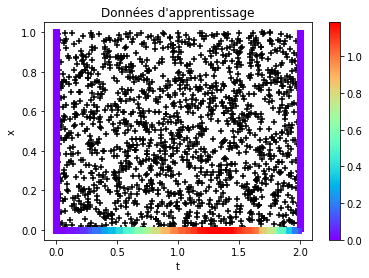

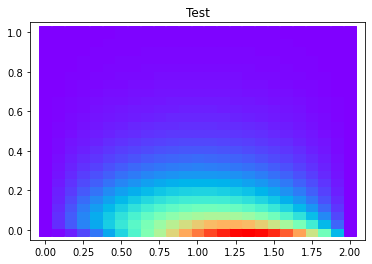

In [160]:
train = torch.utils.data.ConcatDataset((
    DatasetCollocation(),
    DatasetTrainIC(),
    DatasetTrainBounds()
))
# Valdidation des datasets
train_loader = DataLoader(train,shuffle=True, batch_size=len(train))
test = DatasetTest(25,25)
test_loader = DataLoader(test,shuffle=False, batch_size=len(test))

#X,y= next(iter(test_loader))
#plt.scatter(X[:,0],X[:,1],c=y,marker='s',s=40,cmap='rainbow')

X,info= next(iter(train_loader))

plt.scatter(X[info['type']==1,0],
            X[info['type']==1,1],
            marker='+',
            c='black'
           )
plt.scatter(X[info['type']==0,0],
            X[info['type']==0,1],
            c=info['val'][info['type']==0.],
            cmap='rainbow',
            s = 40,marker='s'
           )
plt.colorbar()
plt.xlabel('t')
plt.ylabel('x')
plt.title('Données d\'apprentissage')
#plt.savefig('data_train.jpg')
plt.show()

X,y= next(iter(test_loader))
plt.scatter(X[:,0],X[:,1],c=y,marker='s',s=140,cmap='rainbow')
plt.title('Test')
plt.show()

# Définition du PINN

In [142]:
class Pinn(L.LightningModule):
    def __init__(self,
                 lr:float,
                 *args,
                 **kwargs
                ):
        super().__init__()
        self.save_hyperparameters()

        # réseau estimant u
        self.layers = torch.nn.Sequential(
            torch.nn.Linear(2,32),
            torch.nn.Tanh(),            
            torch.nn.Linear(32,32),
            torch.nn.Tanh(),
            torch.nn.Linear(32,32),
            torch.nn.Tanh(),
            torch.nn.Linear(32,32),
            torch.nn.Tanh(),
            torch.nn.Linear(32,32),
            torch.nn.Tanh(),
            torch.nn.Linear(32,32),
            torch.nn.Tanh(),
            torch.nn.Linear(32,1)
        )
        
        ## loss function
        self.loss_function_BC = torch.nn.MSELoss(reduction ='mean')
        self.loss_function_PDE = torch.nn.MSELoss(reduction ='mean')
        
    def forward(self,p): 
        return self.layers(p)

    def get_residu(self,p):        
        x = p[:,0,None]
        t = p[:,1,None]

        x.requires_grad_(True)
        t.requires_grad_(True)

        u = self.forward(torch.hstack((x,t)))
        
        u_x  = torch.autograd.grad(u, 
                                   x, 
                                   torch.ones_like(u), 
                                   retain_graph=True, 
                                   create_graph=True)[0]
        
        u_xx = torch.autograd.grad(u_x, 
                                   x, 
                                   torch.ones_like(u), 
                                   retain_graph=True, 
                                   create_graph=True)[0]
        
        u_t  = torch.autograd.grad(u  , 
                                   t, 
                                   torch.ones_like(u), 
                                   retain_graph=True, 
                                   create_graph=True)[0]
        
        
        residu = u_t - alpha * u_xx
        
        return residu
        
    def training_step(self,batch):
        p,info = batch
        
        loss_bc = 0
        loss_pde = 0

        # valeurs à la frontière
        select = info['type']==0
        if torch.sum(select)>1:
            loss_bc = self.loss_function_BC(
                self(p[select]),
                info['val'][select]
            )
        # valeur à l’è_intérieur
        select = info['type']==1           
        if torch.sum(select)>1:
            loss_pde = self.loss_function_PDE(
                self.get_residu(
                    p[select]
                    ),
                info['val'][select] # on veut que le résidu soit nulle
            )
            
        loss = loss_bc + 10*loss_pde
        
        self.log('loss',loss)
        self.log('loss_BC',loss_bc)
        self.log('loss_PDE',loss_pde)
        return loss
    
    def predict_step(self,batch):
        p,y = batch
        return self(p),y
        
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(),lr=self.hparams.lr)
        return optimizer

In [ ]:
%%time 
trainer = L.Trainer(max_epochs=5000)
model = Pinn(lr = 1e-3)

train = torch.utils.data.ConcatDataset((
    DatasetCollocation(1500),
    DatasetTrainIC(500),
    DatasetTrainBounds(500)
))

train_loader = DataLoader(train,shuffle=True, batch_size=10000)

trainer.fit(model, train_loader)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name              | Type       | Params | Mode 
---------------------------------------------------------
0 | layers            | Sequential | 5.4 K  | train
1 | loss_function_BC  | MSELoss    | 0      | train
2 | loss_function_PDE | MSELoss    | 0      | train
---------------------------------------------------------
5.4 K     Trainable params
0         Non-trainable params
5.4 K     Total params
0.022     Total estimated model params size (MB)
16        Modules in train mode
0         Modules in eval mode


Training: |                                               | 0/? [00:00<?, ?it/s]

In [ ]:
test = DatasetTest()
#test_loader = DataLoader(test, batch_size=32)
test_loader = DataLoader(test, batch_size=5000)

predictions = trainer.predict(model, test_loader)

In [ ]:
u_pred = [a for a,b in predictions]
exact = [b for a,b in predictions]
u_pred = torch.cat(u_pred).reshape((test.num_test_x,test.num_test_t))
exact = torch.cat(exact).reshape((test.num_test_x,test.num_test_t))

plt.imshow(exact, cmap='rainbow',vmin=0,vmax=1.2)
plt.colorbar()
plt.title('T')
plt.xlabel('t')
plt.ylabel('x')
#plt.savefig('T_reel.png')
plt.show()

plt.imshow(u_pred, cmap='rainbow',vmin=0,vmax=1.2)
plt.colorbar()
plt.title('T predict')
plt.xlabel('t')
plt.ylabel('x')
#plt.savefig('T_predict.png')
plt.show()

In [ ]:
plt.plot(np.linspace(0,2,exact.shape[1]),exact[:,0],'--')
plt.plot(np.linspace(0,2,u_pred.shape[1]),u_pred[:,0])
plt.legend(['exact','prédit'])
plt.title('Prédiction pour t=0')
plt.xlabel('x')
plt.ylabel('T')
plt.ylim([0,1.3])
#plt.savefig('pred_0.jpg')
plt.show()
plt.plot(np.linspace(0,2,exact.shape[1]),exact[:,10],'--')
plt.plot(np.linspace(0,2,u_pred.shape[1]),u_pred[:,10])
#plt.legend(['exact','prédit'])
plt.title('Prédiction pour t='+str(np.round(10/120,2)))
plt.xlabel('x')
plt.ylabel('T')
plt.ylim([0,1.3])
#plt.savefig('pred_10.jpg')
plt.show()
plt.plot(np.linspace(0,2,exact.shape[1]),exact[:,30],'--')
plt.plot(np.linspace(0,2,u_pred.shape[1]),u_pred[:,30])
plt.legend(['exact','prédit'])
plt.title('Prédiction pour t='+str(np.round(30/120,2)))
plt.xlabel('x')
plt.ylabel('T')
plt.ylim([0,1.3])
#plt.savefig('pred_30.jpg')
plt.show()
plt.plot(np.linspace(0,2,exact.shape[1]),exact[:,-1],'--')
plt.plot(np.linspace(0,2,u_pred.shape[1]),u_pred[:,-1])
plt.legend(['exact','prédit'])
plt.title('Prédiction pour t=1')
plt.xlabel('x')
plt.ylabel('T')
plt.ylim([-0.1,1.3])
#plt.savefig('pred_120.jpg')
plt.show()


In [ ]:
error = np.abs(exact - u_pred)

plt.imshow(error, cmap='gist_earth')
#plt.savefig('erreur.jpg')
plt.colorbar()
plt.show()